# Model Explainability

This notebook involves analyzing a Random Forest classifier using the SHAP method. Features that positively and negatively influence the sentiment prediction will be identified. Additionally, one misclassified examples will be examined in detail to understand the reasons behind the errors.


In [5]:
import shap
import yaml
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from src.pipelines import build_text_pipeline

df = pd.read_csv("/app/data/train_test/train_data_prepared.csv", engine='python')
y_train = df['LABEL-is_recommended']
X_train = df['combined_text']
df_test = pd.read_csv("/app/data/train_test/test_data_prepared.csv", engine='python')
y_test = df_test['LABEL-is_recommended']
X_test = df_test['combined_text']

In [4]:
with open("params.yaml") as f:
    params = yaml.safe_load(f)

model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )

pipeline = build_text_pipeline(model, 'bow')


pipeline.fit(X_train, y_train)

Pipeline(steps=[('clean_text', TextCleaner()),
                ('vectorizer', CountVectorizer(max_features=50)),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
cleaner = pipeline.named_steps['clean_text']
vectorizer = pipeline.named_steps['vectorizer']

X_test_clean = cleaner.transform(X_test)
X_test_vec = vectorizer.transform(X_test_clean)

feature_names = vectorizer.get_feature_names_out()
X_test_df = pd.DataFrame(X_test_vec.toarray(), columns=feature_names)

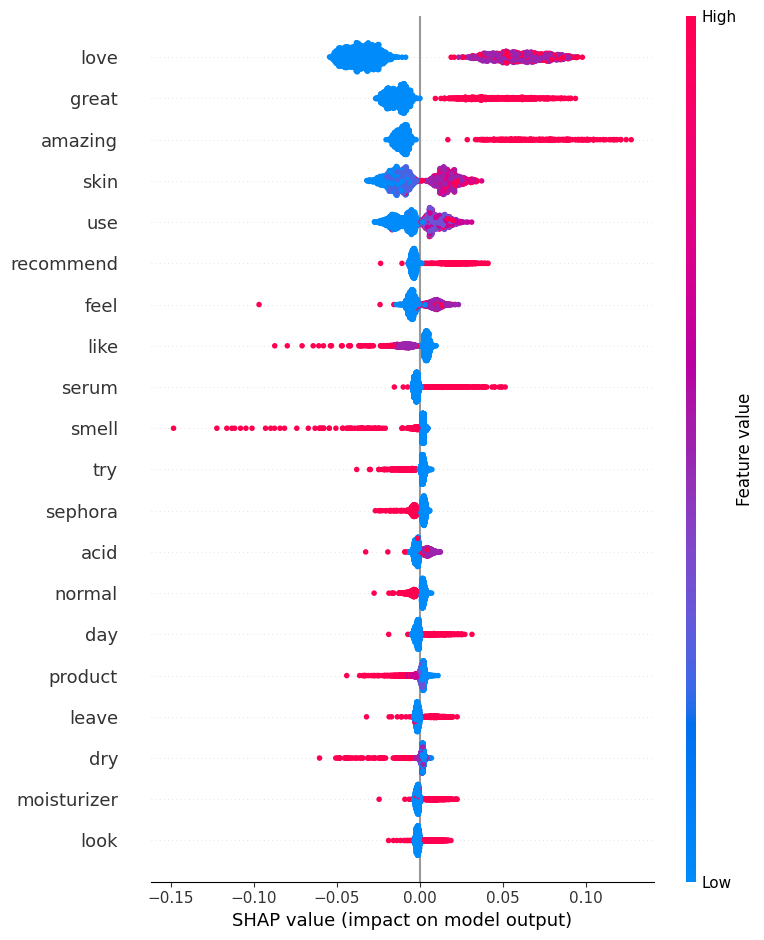

In [ ]:
model = pipeline.named_steps['clf']
explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_test_df)

shap_values_class1 = shap_values[:, :, 1]  # For positive sentiment
shap.summary_plot(shap_values_class1, X_test_df)

The words are ordered from most important (at the top) to less important (at the bottom) in the model. The higher a feature is placed, the greater its global impact on the model's decisions. The words *love*, *great*, and *amazing* had the strongest influence on the model’s predictions, most often indicating a positive sentiment (class 1), which aligns with expectations given their positive connotations. 

The words *skin* and *use* have a much more neutral distribution, thus they could influence both prediction outcomes equally. Words frequently appearing in negative reviews include *like* (potentially preceded by *don't*), as well as words like *smell* and *dry*.


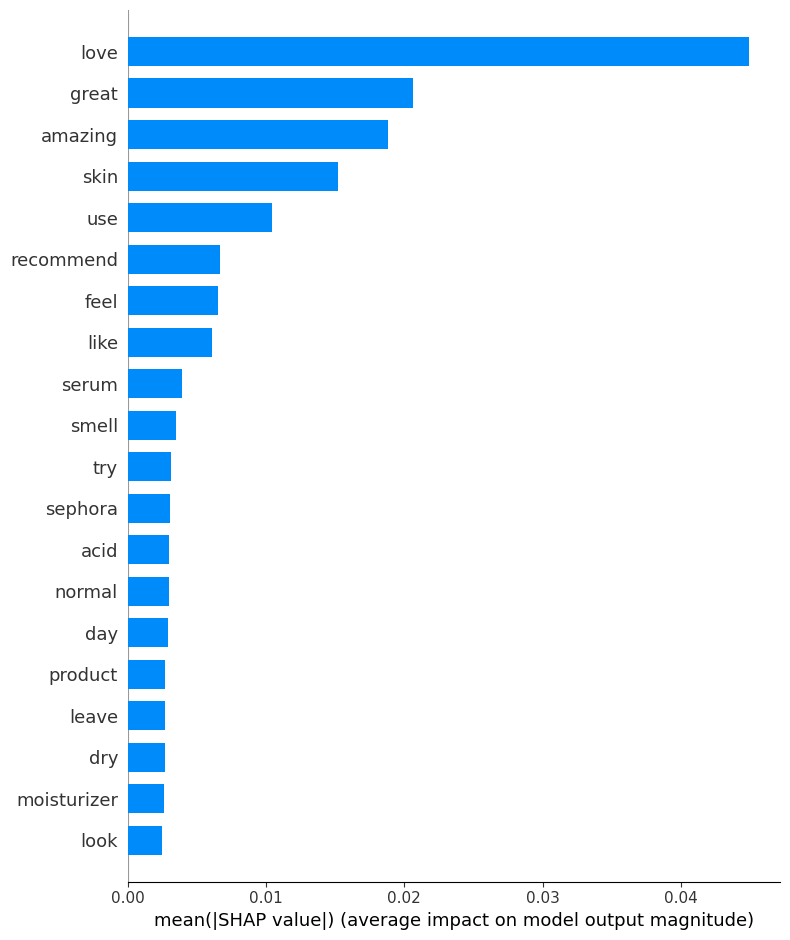

In [30]:
shap.summary_plot(shap_values_class1, X_test_df, plot_type="bar")

Above, we present the average impact (in terms of absolute value) of each word on the model’s decision.

Predykcja: 1.0
Rzeczywista wartość: 0.0
Treść: Everyone always raves about this cleanser, but personally I think it’s nothing special. It cleans, doesn’t strip the skin of moisture, but there’s nothing that would make me run out and buy it. Whenever I get samples I use them, but there are so many other cleansers I love, I’m not about to spend money on this one. Just so so ['Clean at Sephora', 'Best for Dry, Combo, Normal Skin', 'Hydrating', 'Good for: Dryness', 'Good for: Dullness/Uneven Texture', 'Without Parabens']


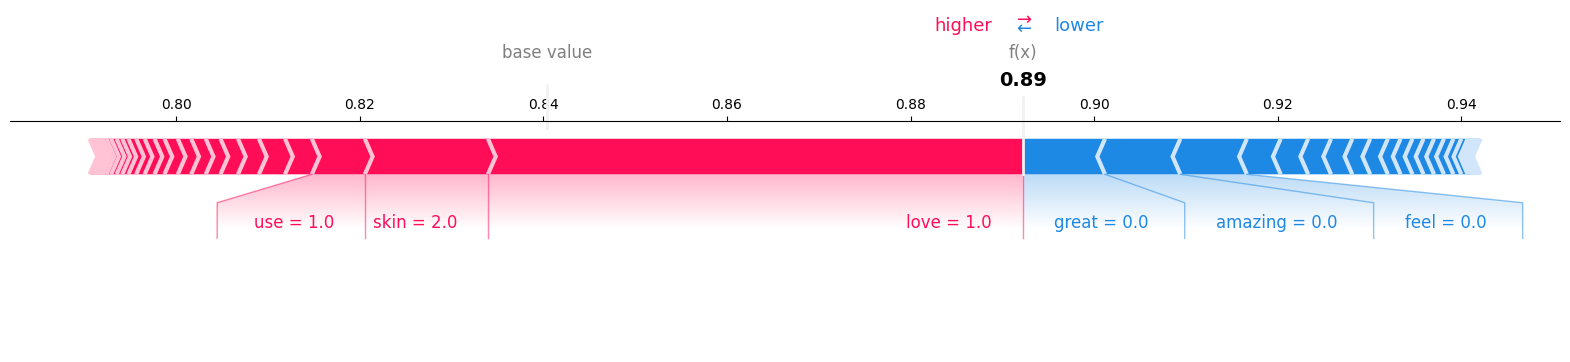

In [35]:
y_pred = pipeline.predict(X_test)

wrong_idxs = np.where(y_pred != y_test)[0]

idx = wrong_idxs[0]
print('Predykcja:', y_pred[idx])
print('Rzeczywista wartość:', y_test[idx])
print('Treść:', X_test[idx])

shap.force_plot(
    explainer.expected_value[1],
    shap_values_class1[idx],
    X_test_df.iloc[idx],
    matplotlib=True
)

In this misclassified case, the model assigned an (incorrect) class probability of 89%. The prediction was especially influenced by the presence of the word *love*, as well as *use* and *skin* (which appeared twice). Here, *love* was used in the context of other products (alternatives to the given product), which misled the model. The absence of the words *great*, *amazing*, and *feel* lowered the classification probability, but not enough to make the prediction correct. 

Overall, the impact of the first three words amounts to about 8 percentage points, indicating that many other factors also contributed to the final prediction.
